In [11]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
earnings_root = "/content/drive/MyDrive/conference_data/mu_earnings_returns.csv"
features_root = "/content/drive/MyDrive/conference_data/mu_transcript_features.csv"

In [3]:
earnings_df = pd.read_csv(earnings_root)
features_df = pd.read_csv(features_root)

In [5]:
features_df["prepared_net_sent"] = (features_df["finbert_prepared_remarks_pos"] - features_df["finbert_prepared_remarks_neg"])
features_df["qa_net_sent"] = (features_df["finbert_qa_management_pos"] - features_df["finbert_qa_management_neg"])

In [6]:
features_df["sent_diff"] = features_df["prepared_net_sent"] - features_df["qa_net_sent"]

In [7]:
df = features_df.merge(
    earnings_df,
    on=["ticker", "quarter"],
    how="inner"
)


In [9]:
df["earnings_date"] = pd.to_datetime(df["earnings_date"])
df = df.sort_values("earnings_date")

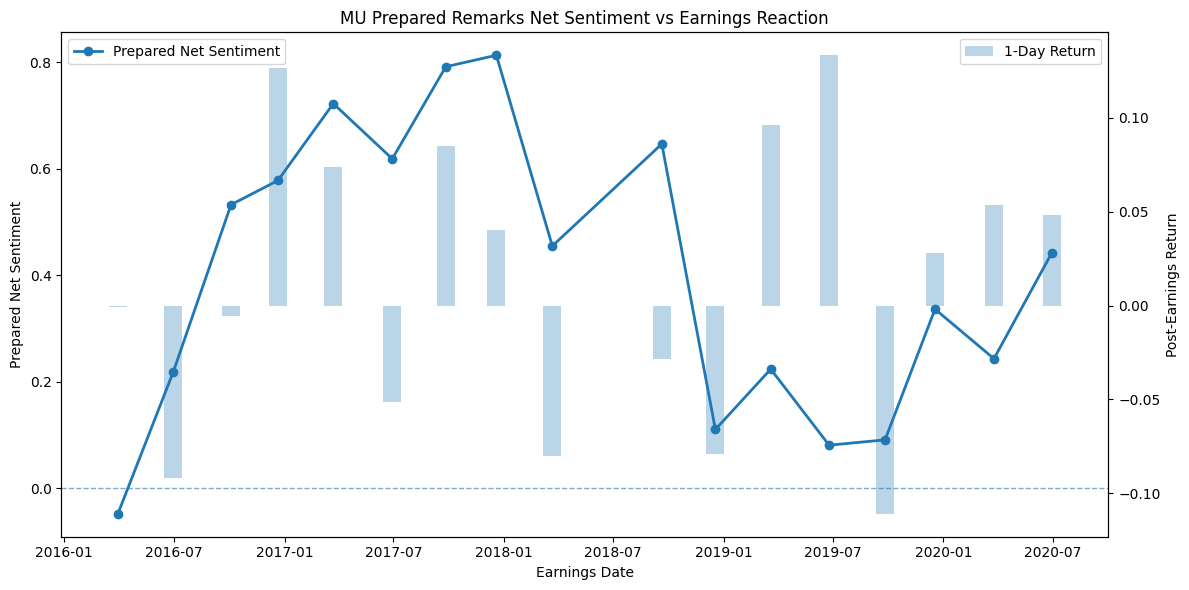

In [13]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Sentiment line
ax1.plot(
    df["earnings_date"],
    df["prepared_net_sent"],
    marker="o",
    linewidth=2,
    label="Prepared Net Sentiment"
)

ax1.set_xlabel("Earnings Date")
ax1.set_ylabel("Prepared Net Sentiment")
ax1.axhline(0, linestyle="--", linewidth=1, alpha=0.6)
ax1.legend(loc="upper left")

# Secondary axis for returns
ax2 = ax1.twinx()
ax2.bar(
    df["earnings_date"],
    df["1_day_return"],
    width=30,
    alpha=0.3,
    label="1-Day Return"
)

ax2.set_ylabel("Post-Earnings Return")
ax2.legend(loc="upper right")

plt.title("MU Prepared Remarks Net Sentiment vs Earnings Reaction")
plt.tight_layout()
plt.show()


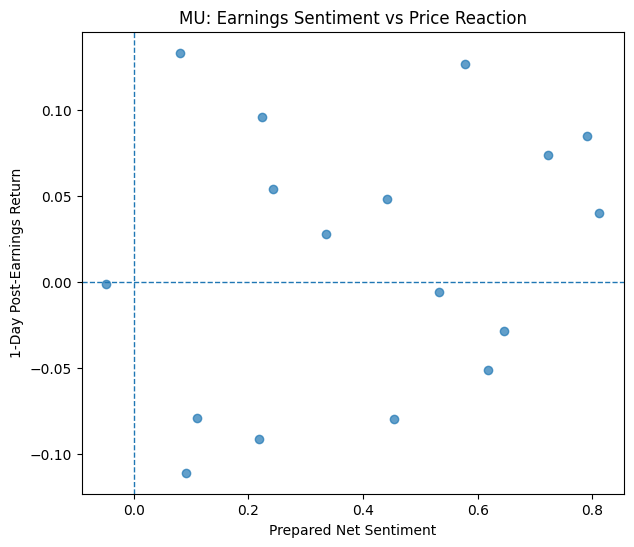

In [14]:
plt.figure(figsize=(7, 6))

plt.scatter(
    df["prepared_net_sent"],
    df["1_day_return"],
    alpha=0.7
)

plt.axhline(0, linestyle="--", linewidth=1)
plt.axvline(0, linestyle="--", linewidth=1)

plt.xlabel("Prepared Net Sentiment")
plt.ylabel("1-Day Post-Earnings Return")
plt.title("MU: Earnings Sentiment vs Price Reaction")

plt.show()


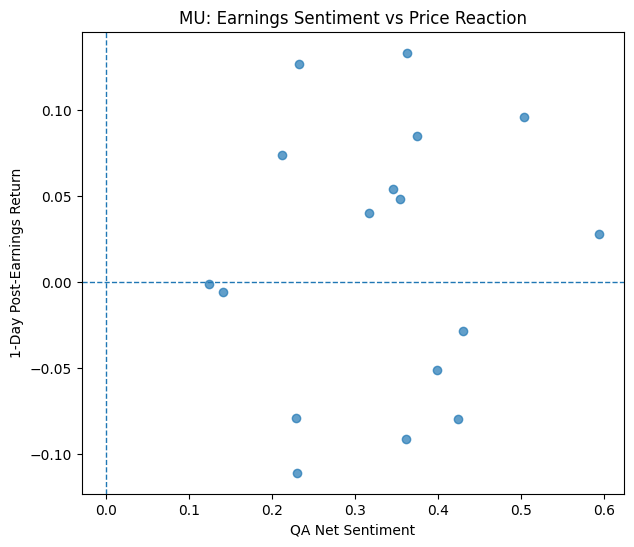

In [17]:
plt.figure(figsize=(7, 6))

plt.scatter(
    df["qa_net_sent"],
    df["1_day_return"],
    alpha=0.7
)

plt.axhline(0, linestyle="--", linewidth=1)
plt.axvline(0, linestyle="--", linewidth=1)

plt.xlabel("QA Net Sentiment")
plt.ylabel("1-Day Post-Earnings Return")
plt.title("MU: Earnings Sentiment vs Price Reaction")

plt.show()


In [18]:
import statsmodels.api as sm

X = sm.add_constant(df["qa_management_length_zscore"])
y = df["uncertainty_count_qa_management"]

model = sm.OLS(y, X).fit()

df["excess_uncertainty_qa"] = model.resid


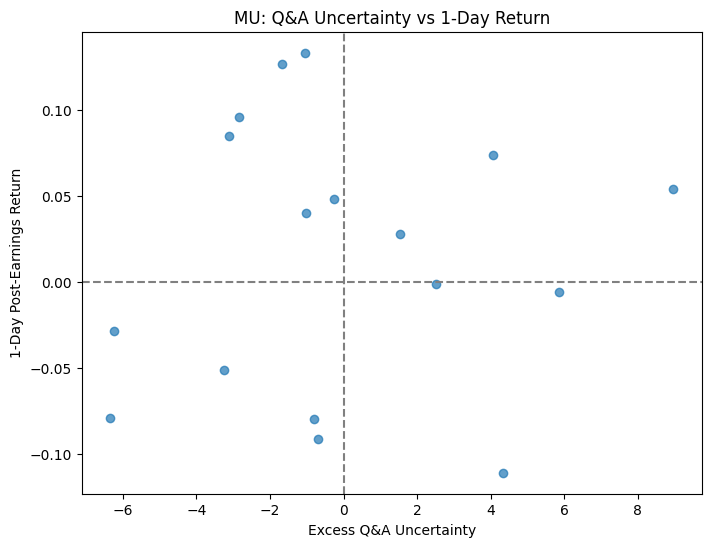

In [19]:
plt.figure(figsize=(8,6))

plt.scatter(
    df["excess_uncertainty_qa"],
    df["1_day_return"],
    alpha=0.7
)

plt.axhline(0, linestyle="--", color="gray")
plt.axvline(0, linestyle="--", color="gray")

plt.xlabel("Excess Q&A Uncertainty")
plt.ylabel("1-Day Post-Earnings Return")
plt.title("MU: Q&A Uncertainty vs 1-Day Return")
plt.show()

/tmp/ipython-input-1694141974.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bucket_returns = df.groupby("unc_bucket")["1_day_return"].mean()


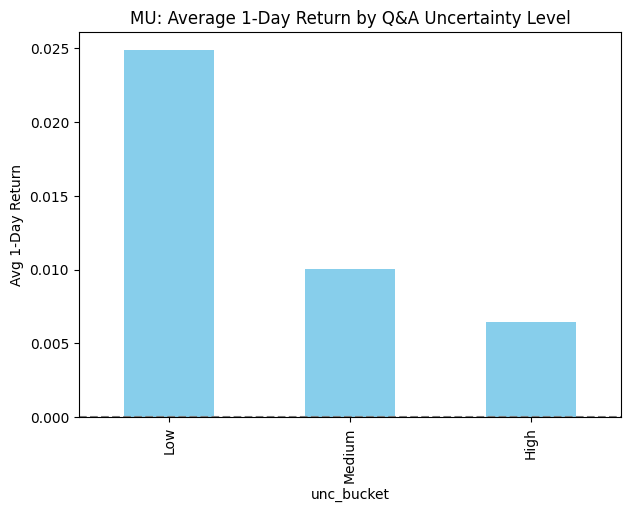

In [20]:
df["unc_bucket"] = pd.qcut(
    df["excess_uncertainty_qa"],
    q=3,
    labels=["Low", "Medium", "High"]
)

bucket_returns = df.groupby("unc_bucket")["1_day_return"].mean()

bucket_returns.plot(kind="bar", figsize=(7,5), color='skyblue')
plt.axhline(0, linestyle="--", color="gray")
plt.ylabel("Avg 1-Day Return")
plt.title("MU: Average 1-Day Return by Q&A Uncertainty Level")
plt.show()


/tmp/ipython-input-3032211418.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bucket_returns = df.groupby("unc_bucket")[["1_day_return", "5_day_return", "10_day_return"]].mean()


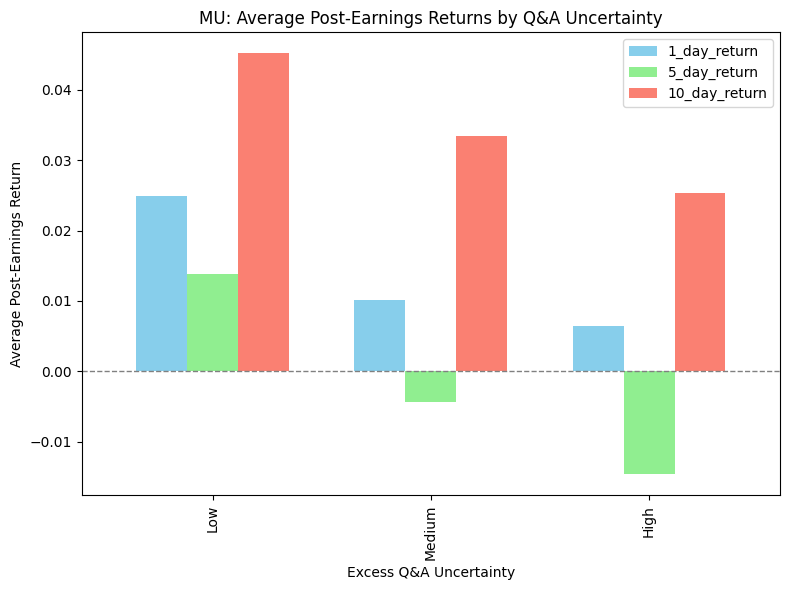

In [24]:
# Bucket excess Q&A uncertainty into 3 groups
df["unc_bucket"] = pd.qcut(
    df["excess_uncertainty_qa"],
    q=3,
    labels=["Low", "Medium", "High"]
)

# Compute average returns per bucket
bucket_returns = df.groupby("unc_bucket")[["1_day_return", "5_day_return", "10_day_return"]].mean()

# Plot multi-bar chart
fig, ax = plt.subplots(figsize=(8,6))

colors = ["skyblue", "lightgreen", "salmon"]

# Let pandas plot and auto-generate legend
bucket_returns.plot(
    kind="bar",
    ax=ax,
    color=colors,
    width=0.7,
    legend=True  # <- important
)

# Add horizontal zero line (does NOT interfere with legend)
ax.axhline(0, linestyle="--", color="gray", linewidth=1)

# Labels and title
ax.set_ylabel("Average Post-Earnings Return")
ax.set_xlabel("Excess Q&A Uncertainty")
ax.set_title("MU: Average Post-Earnings Returns by Q&A Uncertainty")

plt.tight_layout()
plt.show()

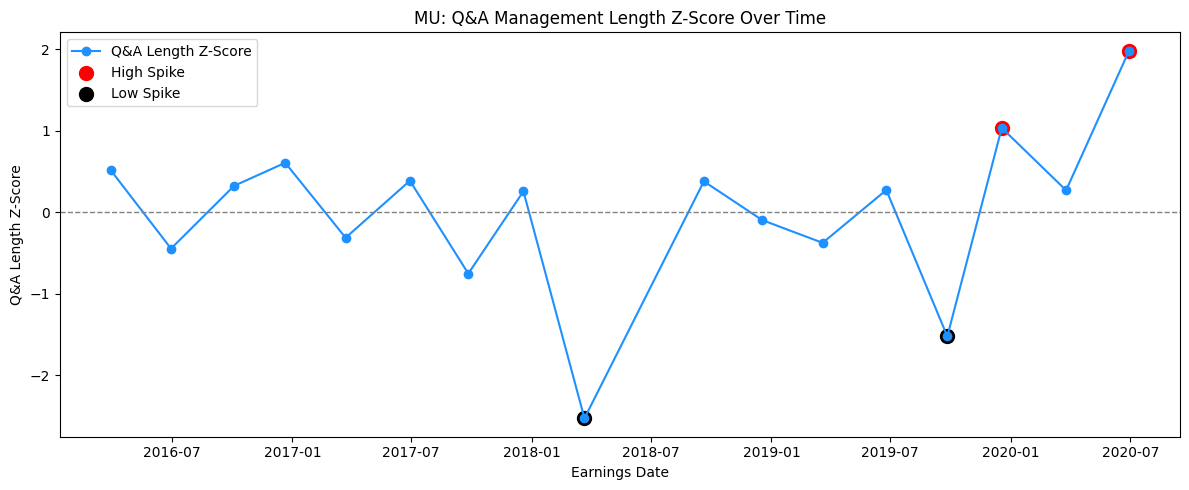

In [26]:
plt.figure(figsize=(12,5))

plt.plot(
    df["earnings_date"],
    df["qa_management_length_zscore"],
    marker='o',
    linestyle='-',
    color='dodgerblue',
    label="Q&A Length Z-Score"
)

# Highlight high and low spikes
high_spikes = df["qa_management_length_zscore"] > 1.0
low_spikes  = df["qa_management_length_zscore"] < -1.0

plt.scatter(
    df.loc[high_spikes, "earnings_date"],
    df.loc[high_spikes, "qa_management_length_zscore"],
    color='red',
    s=100,
    label="High Spike"
)

plt.scatter(
    df.loc[low_spikes, "earnings_date"],
    df.loc[low_spikes, "qa_management_length_zscore"],
    color='black',
    s=100,
    label="Low Spike"
)

plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xlabel("Earnings Date")
plt.ylabel("Q&A Length Z-Score")
plt.title("MU: Q&A Management Length Z-Score Over Time")
plt.legend()
plt.tight_layout()
plt.show()

In [27]:
# Define high and low spikes
high_spikes = df["qa_management_length_zscore"] > 1.0   # unusually long Q&A
low_spikes  = df["qa_management_length_zscore"] < -1.0  # unusually short Q&A

# Optional: medium/no-spike group
medium_spikes = (df["qa_management_length_zscore"].between(-1.0, 1.0))

In [28]:
# Example for 1-day, 5-day, 10-day returns
avg_returns = pd.DataFrame({
    "High Spike": df.loc[high_spikes, ["1_day_return", "5_day_return", "10_day_return"]].mean(),
    "Low Spike": df.loc[low_spikes, ["1_day_return", "5_day_return", "10_day_return"]].mean(),
    "Medium/Other": df.loc[medium_spikes, ["1_day_return", "5_day_return", "10_day_return"]].mean()
}).T

print(avg_returns)


              1_day_return  5_day_return  10_day_return
High Spike        0.038156      0.018903       0.019743
Low Spike        -0.095422     -0.110416      -0.143497
Medium/Other      0.027125      0.012067       0.064418


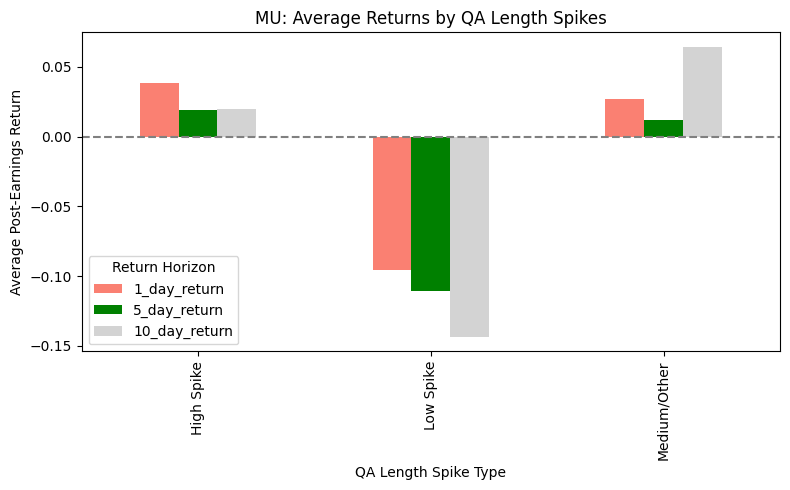

In [29]:
avg_returns.plot(
    kind="bar",
    figsize=(8,5),
    color=["salmon", "green", "lightgray"]
)

plt.ylabel("Average Post-Earnings Return")
plt.xlabel("QA Length Spike Type")
plt.title("MU: Average Returns by QA Length Spikes")
plt.axhline(0, linestyle="--", color="gray")
plt.legend(title="Return Horizon")
plt.tight_layout()
plt.show()
